# Sales Forecasting

In this project we will build predictive models, compare them and use the most appropriate one to forecast sales. We will split the dataset into Training data which will be used to build the model and Holdout data which will be used to test the accuracy of the forecast.

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rc("font", size=14)
import seaborn as sns
sns.set()
sns.set(style="whitegrid", color_codes=True)
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

## Loading the Dataset

In [2]:
# demographic = pd.read_csv('storedemographicdata.csv')
# storeinfo = pd.read_csv('storeinformation.csv')
sales_data = pd.read_csv('store_sales_data.csv')
# all_store_cluster = pd.read_csv('all_store_cluster.csv')

## Exploratory Data Analysis and Data Cleaning

In [3]:
sales_data.head()

,Store,Day,Month,Year,Dry_Grocery,Dairy,Frozen_Food,Meat,Produce,Floral,Deli,Bakery,General_Merchandise
0,S0001,1,3,2012,23401.06,5567.90,3930.28,5223.61,4542.28,238.58,2608.78,1651.77,4304.79
1,S0001,2,3,2012,32442.93,8009.52,4712.31,6174.72,9503.45,245.29,2692.72,2688.89,4467.51
2,S0001,3,3,2012,40433.61,9759.20,5969.03,8010.67,12793.92,282.12,3493.85,2929.85,5721.60
3,S0001,4,3,2012,57043.39,13966.26,9008.24,13142.55,16635.77,316.72,5618.55,4270.38,8313.11
4,S0001,5,3,2012,32894.86,7870.66,5448.35,5459.29,8358.96,198.00,3339.59,2061.21,5280.16


In [4]:
 sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116232 entries, 0 to 116231
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Store                116232 non-null  object 
 1   Day                  116232 non-null  int64  
 2   Month                116232 non-null  int64  
 3   Year                 116232 non-null  int64  
 4   Dry_Grocery          116232 non-null  float64
 5   Dairy                116232 non-null  float64
 6   Frozen_Food          116232 non-null  float64
 7   Meat                 116232 non-null  float64
 8   Produce              116232 non-null  float64
 9   Floral               116232 non-null  float64
 10  Deli                 116232 non-null  float64
 11  Bakery               116232 non-null  float64
 12  General_Merchandise  116232 non-null  float64
dtypes: float64(9), int64(3), object(1)
memory usage: 11.5+ MB


In [5]:
# we will forecast sales for the 'Produce' category
# filter the data
produce_sales = sales_data.iloc[:, np.r_[0,2:4, 8]]
produce_sales.head()

,Store,Month,Year,Produce
0,S0001,3,2012,4542.28
1,S0001,3,2012,9503.45
2,S0001,3,2012,12793.92
3,S0001,3,2012,16635.77
4,S0001,3,2012,8358.96


In [6]:
# check fot null values
produce_sales.isnull().sum()

Store      0
Month      0
Year       0
Produce    0
dtype: int64

In [7]:
# convert date to datetime datatype
produce_sales['Date'] = pd.to_datetime(produce_sales[['Year', 'Month']].assign(Day=1))

# Aggregate monthly Produce sales
monthly_produce_sales=produce_sales.groupby(['Date'])['Produce'].sum()

monthly_produce_sales.head()

Date
2012-03-01    25151525.84
2012-04-01    24406048.39
2012-05-01    28249539.01
2012-06-01    28691364.32
2012-07-01    28535707.45
Name: Produce, dtype: float64

In [8]:
# Split the train and test sets 
sales_train = monthly_produce_sales.iloc[:-6]
sales_test = monthly_produce_sales.iloc[-6:]

In [9]:
# Check the size of training & testing sets
sales_train.shape, sales_test.shape

((40,), (6,))

### Visualize the Monthly Sales Data

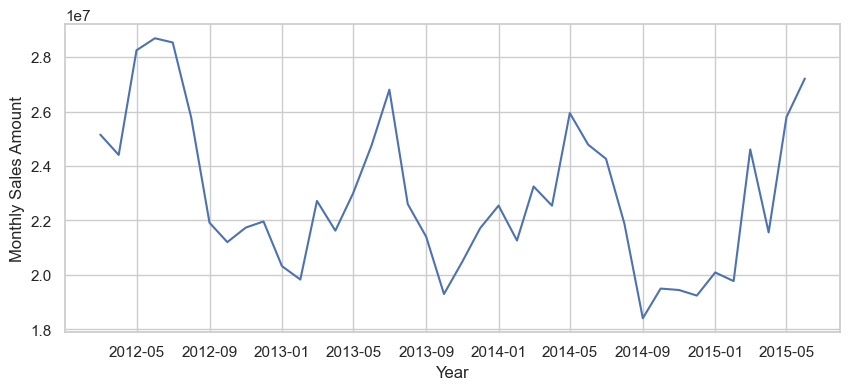

In [10]:
plt.figure(figsize=(10,4))

plt.plot(sales_train.index, sales_train.values)
plt.ylabel('Monthly Sales Amount')
plt.xlabel('Year')

plt.show()

From the monthly sales plot, we notice that the monthly sales exhibits seasonal patterns and a decreasing trend over time. These can be confirmd through the following decomposition plot. 

### Determine Trend, Seasonal, and Error components

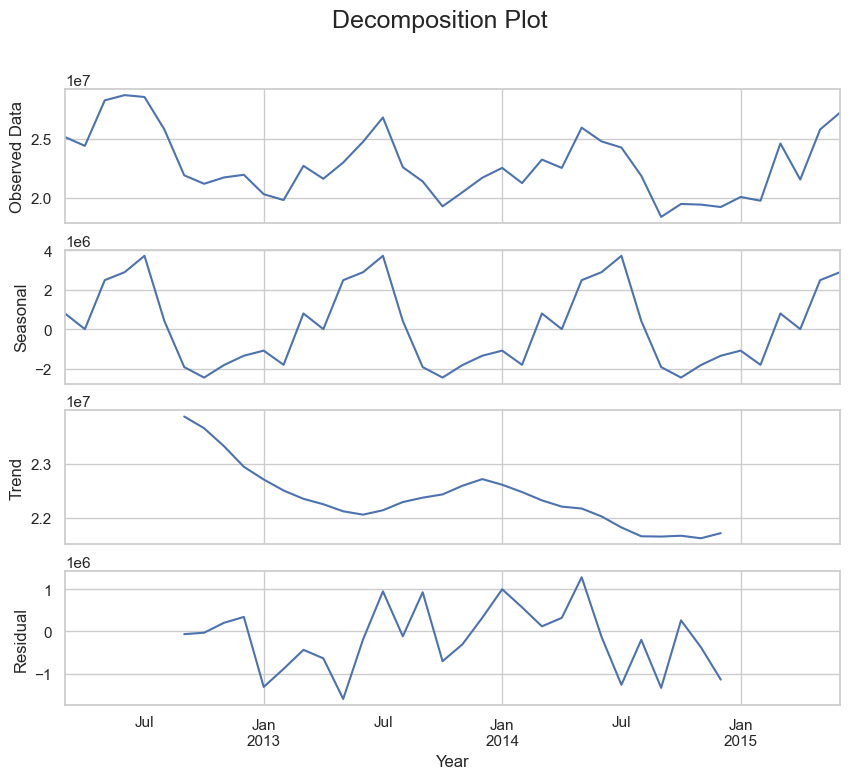

In [11]:
res = seasonal_decompose(sales_train , model='additive', period=12)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,8), sharex= True)
res.observed.plot(ax=ax1)
ax1.set_ylabel('Observed Data')
res.seasonal.plot(ax=ax2)
ax2.set_ylabel('Seasonal')
res.trend.plot(ax=ax3)
ax3.set_ylabel('Trend')
res.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

plt.xlabel("Year")
plt.suptitle('Decomposition Plot',fontsize = 18)

plt.show()

The decomposition plot shows the monthly sales data broken down into its three components: trend, seasonal and the error. Each of these components makes up the time series and helps confirm what we saw in the previous initial time series plot.

### ETS Model

From the decomposition plot, we could obtain the necessary information to define the terms for the ETS model.

The Error changes in magnitude as the series goes along so a multiplicative method will be used.
The Trend line exhibits linear behavior so we will use an no-trend method.
The Seasonality changes in magnitude each year so a multiplicative method seems necessary.

Therefore we need to use and ETS(Multiplicative,None,Multplicative) model

In [12]:
# Import the relevant libraries 
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [13]:
# Define the ETS (M, N, M) model
ets_model = ETSModel(sales_train, 
                     error='mul', trend=None , seasonal = 'mul', 
                     damped_trend=False, seasonal_periods=12, 
                     initial_level=sales_train.values.mean(), freq='MS')
# Fit the model 
ets_fitted = ets_model.fit()

In [14]:
print(ets_fitted.summary())

                                 ETS Results                                  
Dep. Variable:                Produce   No. Observations:                   40
Model:                       ETS(MNM)   Log Likelihood                -607.565
Date:                Tue, 01 Aug 2023   AIC                           1247.131
Time:                        19:49:54   BIC                           1274.153
Sample:                    03-01-2012   HQIC                          1256.901
                         - 06-01-2015   Scale                            0.002
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.6731      0.091      7.396      0.000       0.495       0.852
smoothing_seasonal   3.269e-05        nan        nan        nan         nan         nan
initial_level   

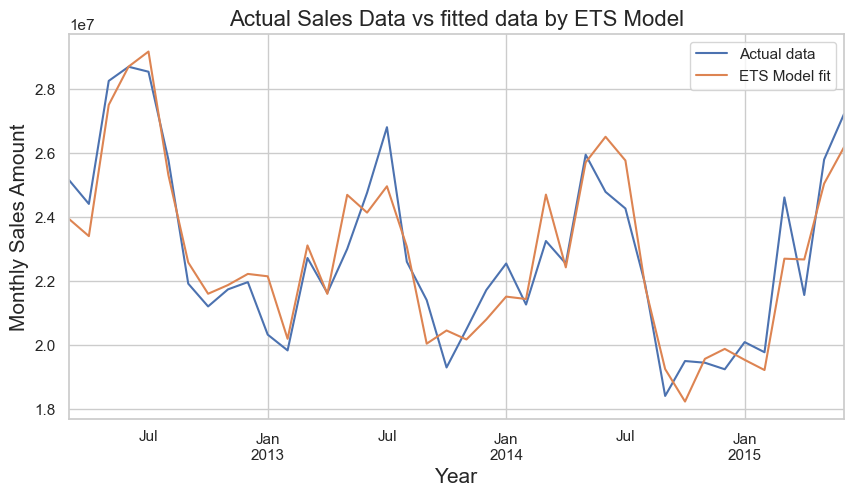

In [15]:
# Visualize the initial data and fitted values 

plt.figure(figsize=(10,5))

sales_train.plot(label='Actual data')
ets_fitted.fittedvalues.plot(label='ETS Model fit')
plt.title('Actual Sales Data vs fitted data by ETS Model' , fontsize=16)
plt.ylabel("Monthly Sales Amount",fontsize = 15)
plt.xlabel("Year",fontsize = 15)
plt.legend();

plt.show()

In [16]:
# Store the predicted values based on ETS model
pred_ets= ets_fitted.fittedvalues

### Evaluate Model Accuracy

We will calculate the following errors to evaluate the accuracy of the model.

- RMSE (Rooted Mean Squared Error)
- MAE (Mean Absolute Error)
- MAPE (Mean Absolute Percentage Error)
- MASE (Mean Absolute Scaled Error)

In [17]:
# values to compare
expected_ets = sales_train.values
predicted_ets = pred_ets.values

In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error

def mean_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred) / y_true * 100)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def running_diff(arr, N):
    return np.array([arr[i] - arr[i-N] for i in range(N, len(arr))])

def mean_absolute_scaled_error(training_series, testing_series, prediction_series):
    errors_mean = np.abs(testing_series - prediction_series ).mean()
    d = np.abs(running_diff(training_series, 12) ).mean()
    return errors_mean/d

mse_ets  = mean_squared_error(expected_ets, predicted_ets)
rmse_ets = sqrt(mse_ets)
mae_ets  = mean_absolute_error(expected_ets, predicted_ets)
mpe_ets  = mean_percentage_error(expected_ets, predicted_ets)
mape_ets = mean_absolute_percentage_error(expected_ets, predicted_ets)
mase_ets = mean_absolute_scaled_error(expected_ets, expected_ets, predicted_ets)

print('In-Sample Error Measures of ETS Models:')
print('')
print('- RMSE: %.3f' % rmse_ets)
print('- MAE : %.3f' % mae_ets)
print('- MPE : %.3f' % mpe_ets)
print('- MAPE: %.3f' % mape_ets)
print('- MASE: %.3f' % mase_ets)

In-Sample Error Measures of ETS Models:

- RMSE: 966118.556
- MAE : 790697.509
- MPE : -0.063
- MAPE: 3.470
- MASE: 0.441


## Seasonal ARIMA

To build a seasonal ARIMA model we need make the data stationary. As we saw above, the data seems to have seasonality and linear Trend. We can use the Augmented Dickey Fuller test whether the data is stationary.

In [19]:
# Augmented Dickey Fuller test

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(sales_train.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.793553
p-value: 0.059201


The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values.

We conclude that the time series is in fact non-stationary.

As usual we will determine the detailed Seasonal ARIMA based on (Seasonal) ACF and PACF plots.

### Time Series ACF and PACF

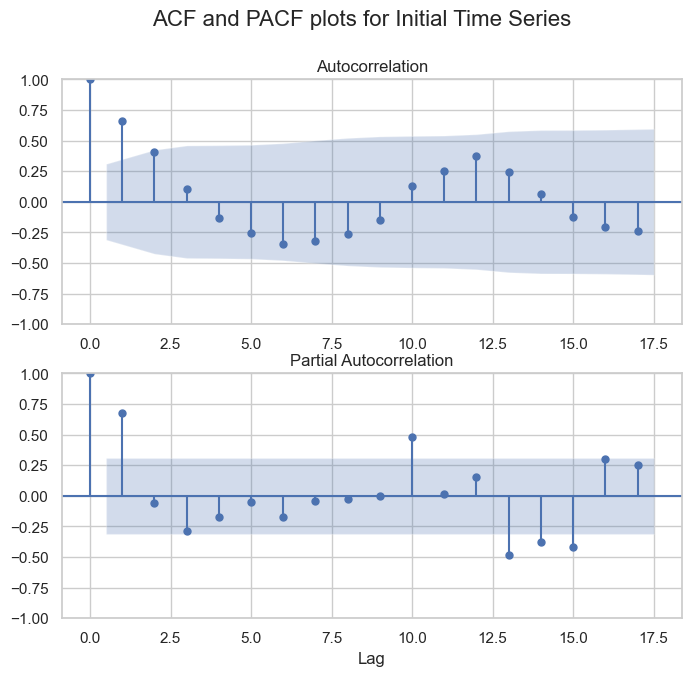

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(211)
fig=plot_acf(sales_train, lags = 17,  ax=ax1)

ax2 = fig.add_subplot(212)
fig=plot_pacf(sales_train, lags = 17, ax=ax2)

plt.xlabel('Lag')
plt.suptitle('ACF and PACF plots for Initial Time Series', fontsize=16)
plt.show()

The ACF plot is not stationary and shows a seasonal pattern. The time series will be differenced to obtain a stationary time series.

### Seasonal Difference ACF and PACF

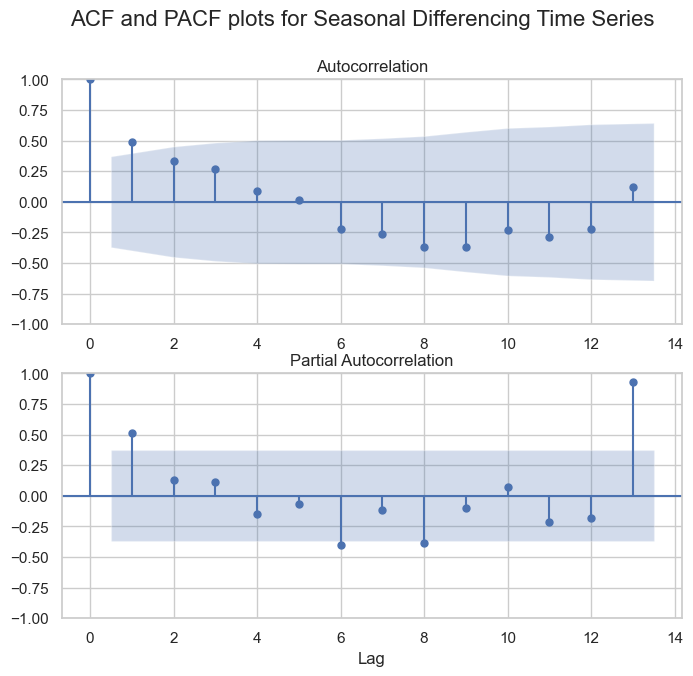

In [21]:
def running_diff(arr, N):
    return np.array([arr[i] - arr[i-N] for i in range(N, len(arr))])

seasonal_diff = running_diff(sales_train, 12) 

fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(211)
fig=plot_acf(seasonal_diff, lags = 13, ax=ax1)

ax2 = fig.add_subplot(212)
fig=plot_pacf(seasonal_diff,lags = 13,  ax=ax2)

plt.xlabel('Lag')
plt.suptitle('ACF and PACF plots for Seasonal Differencing Time Series', fontsize=16)
plt.show()

The ACF plot of Seasonal Differenced is not stationary as well. It shows a seasonal pattern. The time series will be differenced to obtain a stationary time series.

### Seasonal First Difference ACF and PACF

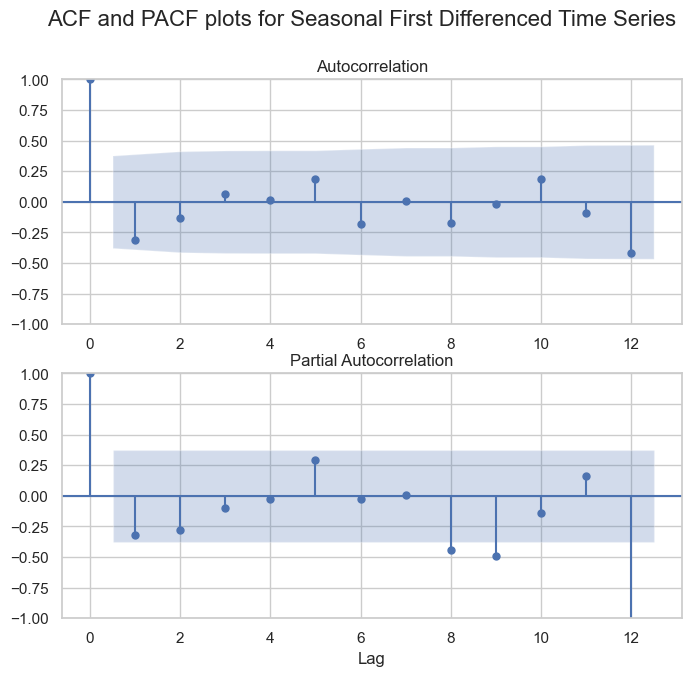

In [22]:
seasonal_diff_1 = running_diff(seasonal_diff, 1) 

fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(211)
fig=plot_acf(seasonal_diff_1, lags=12,  ax=ax1)

ax2 = fig.add_subplot(212)
fig=plot_pacf(seasonal_diff_1, lags=12,  ax=ax2)

plt.xlabel('Lag')
plt.suptitle('ACF and PACF plots for Seasonal First Differenced Time Series', fontsize=16)
plt.show()

- From the ACF and PACF of seasonal first difference, the series seems now stationary. 
- The ACF plot shows a negative correlation at lag-1 which is confirmed in the PACF. This suggests an MA(1) model. In the PACF plot, we can also see plot gradually drops to zero. This indicates MA (1) term (i.e. q =1) as well. 
- Furthermore, since this is a first difference, the value for d = 1. For the seasonal component at lag -12, in both ACF and PACF the component has negative correlation and is significant. Also, since it is the first difference D = 1. The m value is 12 since seasonal duration is 12 months. The ARIMA model is ARIMA(0,1,1)(0,1,0)[12].

### Define the Seasonal ARIMA model

In [23]:
# Define model

model_sarima = sm.tsa.statespace.SARIMAX(sales_train, order=(0,1,1), seasonal_order=(0,1,0,12), 
                                         trend = None , freq ='MS', 
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
# Fit model
sarima_fitted = model_sarima.fit(dynamic=False)
print(sarima_fitted.summary())

                                      SARIMAX Results                                      
Dep. Variable:                             Produce   No. Observations:                   40
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -394.403
Date:                             Tue, 01 Aug 2023   AIC                            792.807
Time:                                     19:49:59   BIC                            795.245
Sample:                                 03-01-2012   HQIC                           793.483
                                      - 06-01-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4436      0.151     -2.931      0.003      -0.740      -0.147
sigma2      3.059e+12   2.1


### Plot Residual Errors

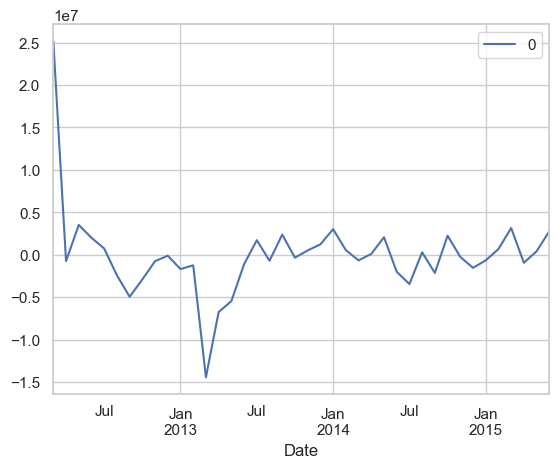

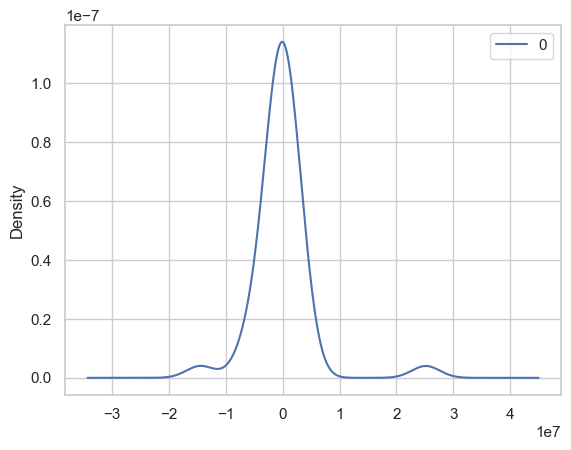

In [24]:
residuals = pd.DataFrame(sarima_fitted.resid)

residuals.plot()
residuals.plot(kind='kde')
plt.show()

In [25]:
print(residuals.describe())

                  0
count  4.000000e+01
mean  -7.045448e+04
std    5.191349e+06
min   -1.443119e+07
25%   -1.578415e+06
50%   -2.967130e+05
75%    1.346422e+06
max    2.515153e+07


### Evaluate model Accuracy

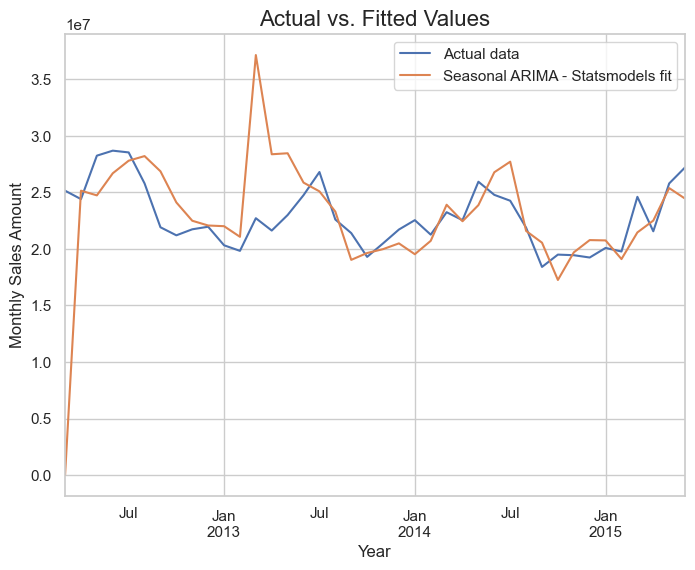

In [26]:
# Compare actual vs Fitted values

sales_train.plot(label='Actual data',figsize=(8,6))
pred = sarima_fitted.predict()
pred.plot(label='Seasonal ARIMA - Statsmodels fit')

plt.ylabel("Monthly Sales Amount");
plt.xlabel("Year")
plt.title('Actual vs. Fitted Values', fontsize= 16)
plt.legend()
plt.show();

In [27]:
predicted_sarima = sarima_fitted.predict().values
expected_sarima = sales_train.values

mse_sarima  = mean_squared_error(expected_sarima, predicted_sarima)
rmse_sarima = sqrt(mse_sarima)
mae_sarima  = mean_absolute_error(expected_sarima, predicted_sarima)
mpe_sarima  = mean_percentage_error(expected_sarima, predicted_sarima)
mape_sarima = mean_absolute_percentage_error(expected_sarima, predicted_sarima)
mase_sarima = mean_absolute_scaled_error(expected_sarima, expected_sarima, predicted_sarima)

print('In-Sample Error Measures of Seasonal ARIMA Models:')
print(' ')
print('- RMSE : %f' % rmse_sarima)
print('- MAE  : %f' % mae_sarima)
print('- MPE  : %f' % mpe_sarima)
print('- MAPE : %f' % mape_sarima)
print('- MASE : %f' % mase_sarima)

In-Sample Error Measures of Seasonal ARIMA Models:
 
- RMSE : 5126530.255075
- MAE  : 2693244.056517
- MPE  : -0.907254
- MAPE : 11.538478
- MASE : 1.503447


### Predicting the test data

In [28]:
# ETS Model for Validation 
ets_model_holdout = ETSModel(monthly_produce_sales, 
                             error='mul', trend=None , seasonal = 'mul', 
                             damped_trend=False, seasonal_periods=12, 
                             initial_level=monthly_produce_sales.values.mean(), 
                             freq='MS')

ets_fitted_holdout = ets_model_holdout.fit()

In [29]:
test_ets_pred = ets_fitted_holdout.predict()[-6:]

test_ets_pred

2015-07-01    2.703650e+07
2015-08-01    2.340865e+07
2015-09-01    2.057127e+07
2015-10-01    2.022153e+07
2015-11-01    2.110754e+07
2015-12-01    2.160625e+07
Freq: MS, dtype: float64

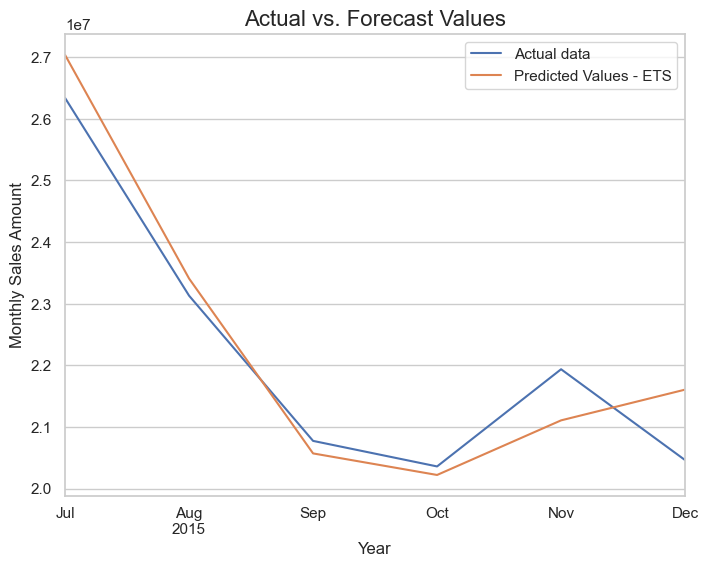

In [30]:
# Compare actual vs Fitted values

sales_test.plot(label='Actual data',figsize=(8,6))
test_ets_pred.plot(label='Predicted Values - ETS')

plt.ylabel("Monthly Sales Amount");
plt.xlabel("Year")
plt.title('Actual vs. Forecast Values', fontsize= 16)
plt.legend()
plt.show();

In [31]:
# Seasonal ARIMA Model for Validation
model_sarima_holdout = sm.tsa.statespace.SARIMAX(monthly_produce_sales, 
                                                 order=(0,1,1), seasonal_order=(0,1,0,12), 
                                                 trend = None , freq ='MS', 
                                                 enforce_stationarity=False, 
                                                 enforce_invertibility=False)

sarima_fitted_holdout = model_sarima_holdout.fit(dynamic=False)

In [32]:
test_sarima_pred = sarima_fitted_holdout.predict()[-6:]
test_sarima_pred

2015-07-01    2.546165e+07
2015-08-01    2.356473e+07
2015-09-01    1.985129e+07
2015-10-01    2.145348e+07
2015-11-01    2.079431e+07
2015-12-01    2.122352e+07
Freq: MS, Name: predicted_mean, dtype: float64

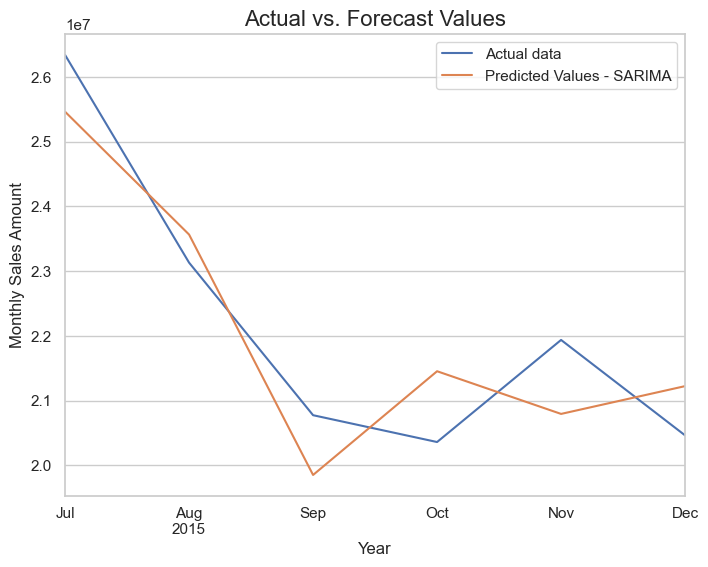

In [33]:
# Compare actual vs Fitted values

sales_test.plot(label='Actual data',figsize=(8,6))
test_sarima_pred.plot(label='Predicted Values - SARIMA')

plt.ylabel("Monthly Sales Amount");
plt.xlabel("Year")
plt.title('Actual vs. Forecast Values', fontsize= 16)
plt.legend()
plt.show();

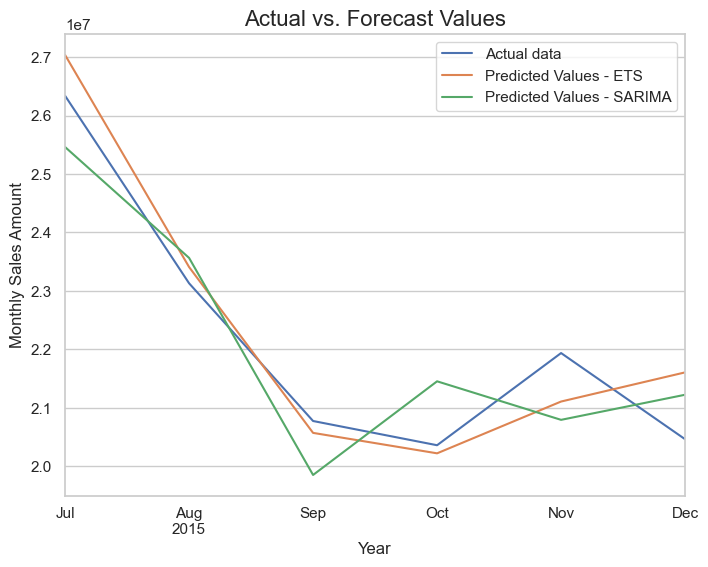

In [34]:
# showing predicted values of both models on the same plot

sales_test.plot(label='Actual data',figsize=(8,6))
test_ets_pred.plot(label='Predicted Values - ETS')
test_sarima_pred.plot(label='Predicted Values - SARIMA')

plt.ylabel("Monthly Sales Amount");
plt.xlabel("Year")
plt.title('Actual vs. Forecast Values', fontsize= 16)
plt.legend()
plt.show();

#### Test Data Errors Comparison

In [35]:
# Test Data Errors Comparison

#store predicted values for both models
holdout_results = pd.DataFrame({'actual': sales_test.values, 
                                 'predicted_ETS': ets_fitted_holdout.predict()[-6:].values, 
                                 'predicted_ARIMA': sarima_fitted_holdout.predict()[-6:].values },
                                index = sales_test.index) 


# calculate errors for ETS model
mse_ets_hos  = mean_squared_error(sales_test.values, holdout_results['predicted_ETS'])
rmse_ets_hos = sqrt(mse_ets_hos)
mae_ets_hos  = mean_absolute_error(sales_test.values, holdout_results['predicted_ETS'])
mpe_ets_hos  = mean_percentage_error(sales_test.values, holdout_results['predicted_ETS'])
mape_ets_hos = mean_absolute_percentage_error(sales_test.values, holdout_results['predicted_ETS'])
mase_ets_hos = mean_absolute_scaled_error(sales_train.values, sales_test.values, 
                                         holdout_results['predicted_ETS'])

print('Test Data Error Measures of ETS Model:')
print(' ')
print('- RMSE : %.3f' % rmse_ets_hos)
print('- MAE  : %.3f' % mae_ets_hos)
print('- MPE  : %.3f' % mpe_ets_hos)
print('- MAPE : %.3f' % mape_ets_hos)
print('- MASE : %.3f' % mase_ets_hos)
print(' ')

# calculate errors - (Seasonal) ARIMA Model
mse_sarima_hos  = mean_squared_error(sales_test.values, holdout_results['predicted_ARIMA'])
rmse_sarima_hos = sqrt(mse_sarima_hos)
mae_sarima_hos  = mean_absolute_error(sales_test.values, holdout_results['predicted_ARIMA'])
mpe_sarima_hos  = mean_percentage_error(sales_test.values, holdout_results['predicted_ARIMA'])
mape_sarima_hos = mean_absolute_percentage_error(sales_test.values, holdout_results['predicted_ARIMA'])
mase_sarima_hos = mean_absolute_scaled_error(sales_train.values, sales_test.values,  
                                           holdout_results['predicted_ARIMA'])
print(' ')
print('Test Data Error Measures of Seasonal ARIMA Model:')
print(' ')
print('- RMSE : %.3f' % rmse_sarima_hos)
print('- MAE  : %.3f' % mae_sarima_hos)
print('- MPE  : %.3f' % mpe_sarima_hos)
print('- MAPE : %.3f' % mape_sarima_hos)
print('- MASE : %.3f' % mase_sarima_hos)

Test Data Error Measures of ETS Model:
 
- RMSE : 660817.982
- MAE  : 548394.559
- MPE  : -0.667
- MAPE : 2.480
- MASE : 0.306
 
 
Test Data Error Measures of Seasonal ARIMA Model:
 
- RMSE : 902703.681
- MAE  : 871795.211
- MPE  : 0.336
- MAPE : 3.991
- MASE : 0.487


When we compare the accuracy measures of each model, we can notice that ETS (M, N, M) model shows better performance according to the most of test data error measurements. 

Therefore we will use the **ETS (M, N, M)** model to forecast sales for the next 12 months


### Forecast for the next 12 months of Sales

In [36]:
# ETS Model for Forecasting 
ets_model_final = ETSModel(monthly_produce_sales, 
                             error='mul', trend=None , seasonal = 'mul', 
                             damped_trend=False, seasonal_periods=12, 
                             initial_level=monthly_produce_sales.values.mean(), 
                             freq='MS')

ets_fitted_final = ets_model_final.fit()

In [37]:
ets_fitted_final.forecast(12)

2016-01-01    2.112908e+07
2016-02-01    2.040875e+07
2016-03-01    2.363877e+07
2016-04-01    2.237553e+07
2016-05-01    2.557682e+07
2016-06-01    2.622294e+07
2016-07-01    2.642650e+07
2016-08-01    2.325822e+07
2016-09-01    2.059294e+07
2016-10-01    2.011786e+07
2016-11-01    2.090930e+07
2016-12-01    2.088702e+07
Freq: MS, Name: simulation, dtype: float64

In [38]:
pred = ets_fitted_final.get_prediction(start='2016-01-01', end='2016-12-01')

In [39]:
df_95 = pred.summary_frame(alpha=0.05)
df_95.rename(columns = {'mean': 'forecast', 
                        'pi_lower': 'forecast_low_95', 
                        'pi_upper': 'forecast_high_95' }, inplace = True)

In [40]:
df_80 = pred.summary_frame(alpha=0.20)
df_80.rename(columns = {'mean': 'forecast', 
                        'pi_lower': 'forecast_low_80', 
                        'pi_upper': 'forecast_high_80' }, inplace = True)

In [41]:
forecast_results= df_95.merge(df_80[['forecast_low_80', 'forecast_high_80']], how = 'inner',left_on = df_95.index,
                                  right_index= True).iloc[:,1:]
forecast_results

,forecast,mean_numerical,forecast_low_95,forecast_high_95,forecast_low_80,forecast_high_80
2016-01-01,2.112908e+07,2.112912e+07,1.927828e+07,2.280181e+07,2.005373e+07,2.217421e+07
2016-02-01,2.040875e+07,2.050958e+07,1.865470e+07,2.246731e+07,1.924890e+07,2.174359e+07
2016-03-01,2.363877e+07,2.375776e+07,2.133386e+07,2.637402e+07,2.208503e+07,2.551435e+07
2016-04-01,2.237553e+07,2.247191e+07,1.999070e+07,2.518244e+07,2.075237e+07,2.418403e+07
2016-05-01,2.557682e+07,2.566086e+07,2.251248e+07,2.892210e+07,2.351881e+07,2.772504e+07
2016-06-01,2.622294e+07,2.635252e+07,2.287296e+07,2.990451e+07,2.395950e+07,2.869500e+07
2016-07-01,2.642650e+07,2.651133e+07,2.288733e+07,3.049939e+07,2.399928e+07,2.919779e+07
2016-08-01,2.325822e+07,2.329558e+07,1.961555e+07,2.712254e+07,2.090367e+07,2.566806e+07
2016-09-01,2.059294e+07,2.058924e+07,1.730359e+07,2.414024e+07,1.839197e+07,2.294534e+07
2016-10-01,2.011786e+07,2.013582e+07,1.676733e+07,2.372523e+07,1.788891e+07,2.249541e+07


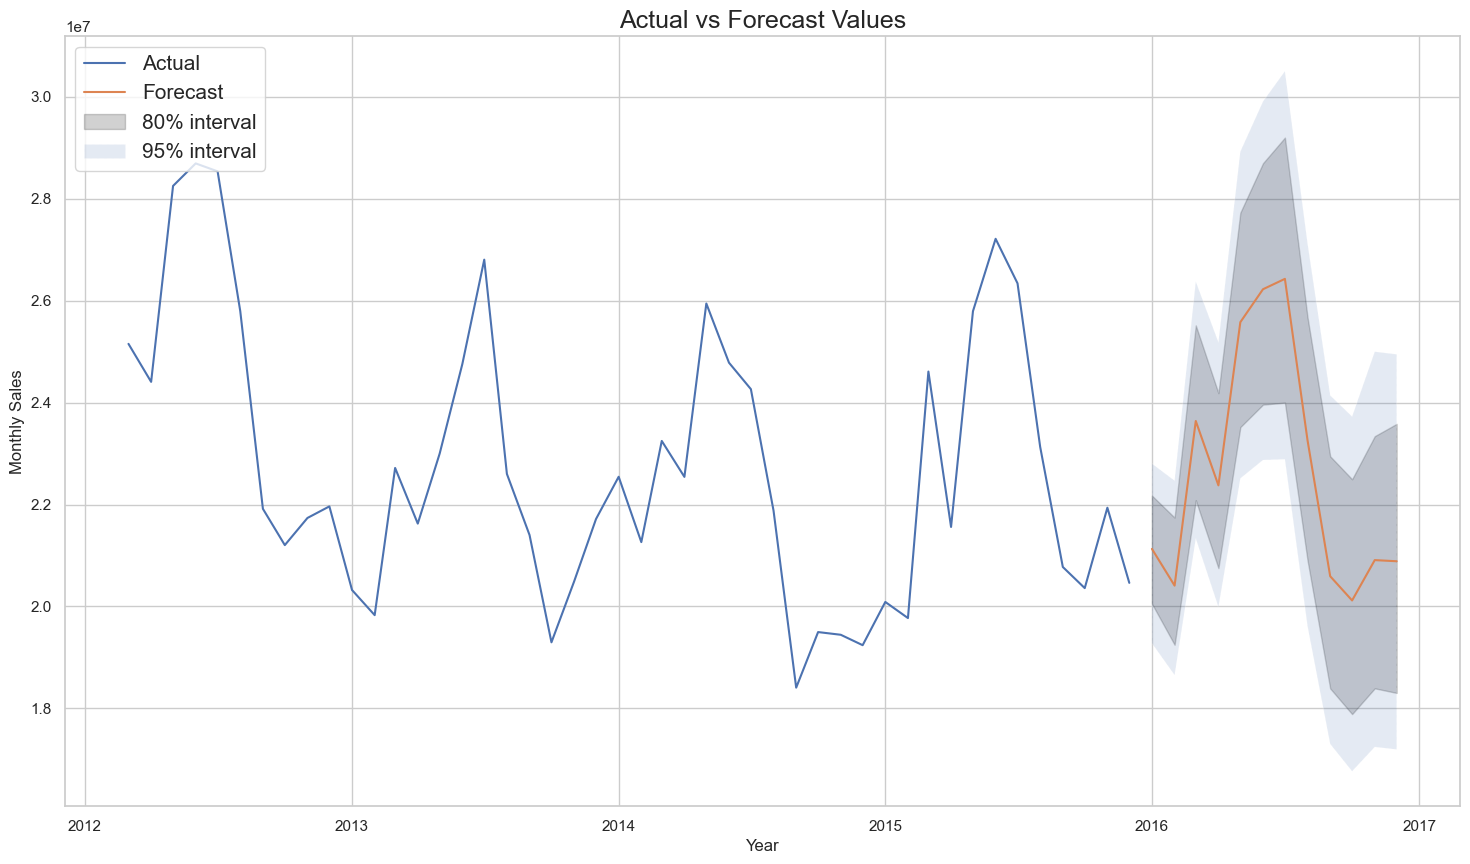

In [42]:
# Visualize the forecast results

plt.figure(figsize=(18,10))

plt.plot(monthly_produce_sales.index, monthly_produce_sales.values)
plt.plot(forecast_results.index,forecast_results.forecast)


plt.fill_between(forecast_results.index, 
                 forecast_results.forecast_low_80.values, 
                 forecast_results.forecast_high_80.values, 
                 color='k', alpha = 0.2, label='80% interval')

plt.fill_between(forecast_results.index, 
                 forecast_results.forecast_low_95.values, 
                 forecast_results.forecast_high_95.values, 
                 color= None,linestyle ='--', alpha=.15,  label='95% interval')

plt.legend(["Actual", "Forecast", "80% interval", "95% interval" ],loc = 'upper left', fontsize =15)
plt.xlabel('Year')
plt.ylabel('Monthly Sales')
plt.title('Actual vs Forecast Values', fontsize = 18)

plt.show()
